# CV ASSIGNMENT 4
# SAI MANOHAR VEMURI
# A20514848

In [1]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy
from scipy import ndimage

# 1.B

In [45]:
import pandas as pd
df = pd.read_csv('../data/annotations/list.txt', skiprows=6, delimiter=" ", names=["image_name", "class_id", "species", "breed_id"])

In [46]:
df

image_name  class_id  species  breed_id
0           Abyssinian_100         1        1         1
1           Abyssinian_101         1        1         1
2           Abyssinian_102         1        1         1
3           Abyssinian_103         1        1         1
4           Abyssinian_104         1        1         1
...                    ...       ...      ...       ...
7344  yorkshire_terrier_96        37        2        25
7345  yorkshire_terrier_97        37        2        25
7346  yorkshire_terrier_98        37        2        25
7347  yorkshire_terrier_99        37        2        25
7348   yorkshire_terrier_9        37        2        25

[7349 rows x 4 columns]

In [47]:
df["category"] = ""
df.loc[(df["species"]==1) & (df["breed_id"]>=1) & (df["breed_id"]<=12), "category"] = "cat"
df.loc[(df["species"]==2) & (df["breed_id"]>=1) & (df["breed_id"]<=25), "category"] = "dog"

In [48]:
df

image_name  class_id  species  breed_id category
0           Abyssinian_100         1        1         1      cat
1           Abyssinian_101         1        1         1      cat
2           Abyssinian_102         1        1         1      cat
3           Abyssinian_103         1        1         1      cat
4           Abyssinian_104         1        1         1      cat
...                    ...       ...      ...       ...      ...
7344  yorkshire_terrier_96        37        2        25      dog
7345  yorkshire_terrier_97        37        2        25      dog
7346  yorkshire_terrier_98        37        2        25      dog
7347  yorkshire_terrier_99        37        2        25      dog
7348   yorkshire_terrier_9        37        2        25      dog

[7349 rows x 5 columns]

# 1.C

In [49]:
import os
annotations_dir=r'../data/annotations/trimaps'
img_dir=r'../data/images'
img_files = [f for f in os.listdir(annotations_dir) if not f.startswith('._') and f.endswith('.png')]

In [50]:
final=[]
for i in range(len(img_files)):
    try:
        k=str(df.loc[df['image_name']==img_files[i][:-4]]['category'].values[0])
        final.append([img_files[i],k])
    except:
        pass

In [51]:
categorized_img_dir = os.path.join(img_dir, 'categorized', 'images')
categorized_mask_dir = os.path.join(img_dir, 'categorized', 'masks')

In [11]:
import shutil
images = []
masks=[]
i=0
j=0

if not os.path.exists(categorized_img_dir):
    os.makedirs(categorized_img_dir)
if not os.path.exists(categorized_mask_dir):
    os.makedirs(categorized_mask_dir)

for f in final:
    mask_img_path = os.path.join(annotations_dir, f[0])
    img_path=os.path.join(img_dir, f[0]).replace(".png", ".jpg")

    if f[1]=='cat': 
        if os.path.exists(categorized_img_dir+'\\'+f[1]+'_'+str(i)+'.jpg'):
            i+=1
        shutil.copy2(img_path,os.path.join(categorized_img_dir, f"cat_{i}.jpg"))
        shutil.copy2(mask_img_path,os.path.join(categorized_mask_dir, f"cat_{i}.jpg"))
    else:
        if os.path.exists(categorized_img_dir+'\\'+f[1]+'_'+str(j)+'.jpg'):
            j+=1
        shutil.copy2(img_path,os.path.join(categorized_img_dir, f"dog_{j}.jpg"))
        shutil.copy2(mask_img_path,os.path.join(categorized_mask_dir, f"dog_{j}.jpg"))
        

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
IMG_DIR=categorized_img_dir
MASK_DIR=categorized_mask_dir
training_data=[]
mask_data=[]

def train_data():
    for img in os.listdir(IMG_DIR):
        try:
            img_array = cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(IMG_DIR,img)), cv2.COLOR_BGR2RGB), (128,128))
            
            mask_array=cv2.resize(cv2.imread(os.path.join(MASK_DIR,img),cv2.IMREAD_GRAYSCALE), (128,128))
           
            training_data.append(img_array)
            mask_data.append(mask_array)
        except Exception as e:
            pass
train_data()

In [53]:
def preprocess_data(training_data,masks):
    images=np.array(training_data)
    images=images.astype('float64')
    print(images.dtype)
    masks=np.array(mask_data)
    masks=masks.astype('float64')
    print(masks.dtype)
    masks[masks==3]=255
    masks[masks==1]=255
    masks[masks==2]=0
    kernel = np.ones((3,3))
    for i in range(len(masks)):
        masks[i] = cv2.morphologyEx(masks[i], cv2.MORPH_CLOSE, kernel)
    images/=255
    masks/=255
    return images,masks

images,masks=preprocess_data(training_data,mask_data)

float64
float64


In [54]:
print(images.shape)
print(masks.shape)

(7349, 128, 128, 3)
(7349, 128, 128)


In [55]:
combined = list(zip(images, masks))
random.seed(42)
random.shuffle(combined)
images[:], masks[:] = zip(*combined)

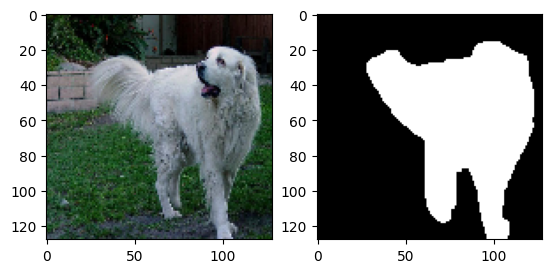

In [56]:
plt.subplot(121)
plt.imshow(images[2000])
plt.subplot(122)
plt.imshow(masks[2000],'gray')
plt.show()

# 1.D

In [57]:
train_size=int(images.shape[0]*0.6)
test_size=int(images.shape[0]*0.2)
validation_size=int(images.shape[0]*0.2)

Xtrain=images[:train_size]
ytrain=masks[:train_size]

Xval=images[train_size:train_size+validation_size]
yval=masks[train_size:train_size+validation_size]

Xtest=images[train_size+validation_size:]
ytest=masks[train_size+validation_size:]

print(Xtrain.shape)
print(ytrain.shape)
print()
print(Xval.shape)
print(yval.shape)
print()
print(Xtest.shape)
print(ytest.shape)

(4409, 128, 128, 3)
(4409, 128, 128)

(1469, 128, 128, 3)
(1469, 128, 128)

(1471, 128, 128, 3)
(1471, 128, 128)


# 1.E

In [24]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, concatenate, Activation, LeakyReLU,BatchNormalization,Conv2D,add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD,Adagrad
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input,Dropout,add,BatchNormalization
import numpy as np
from tensorflow.keras.losses import BinaryCrossentropy


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization_35 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 128, 128, 32)      0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 64)        1849

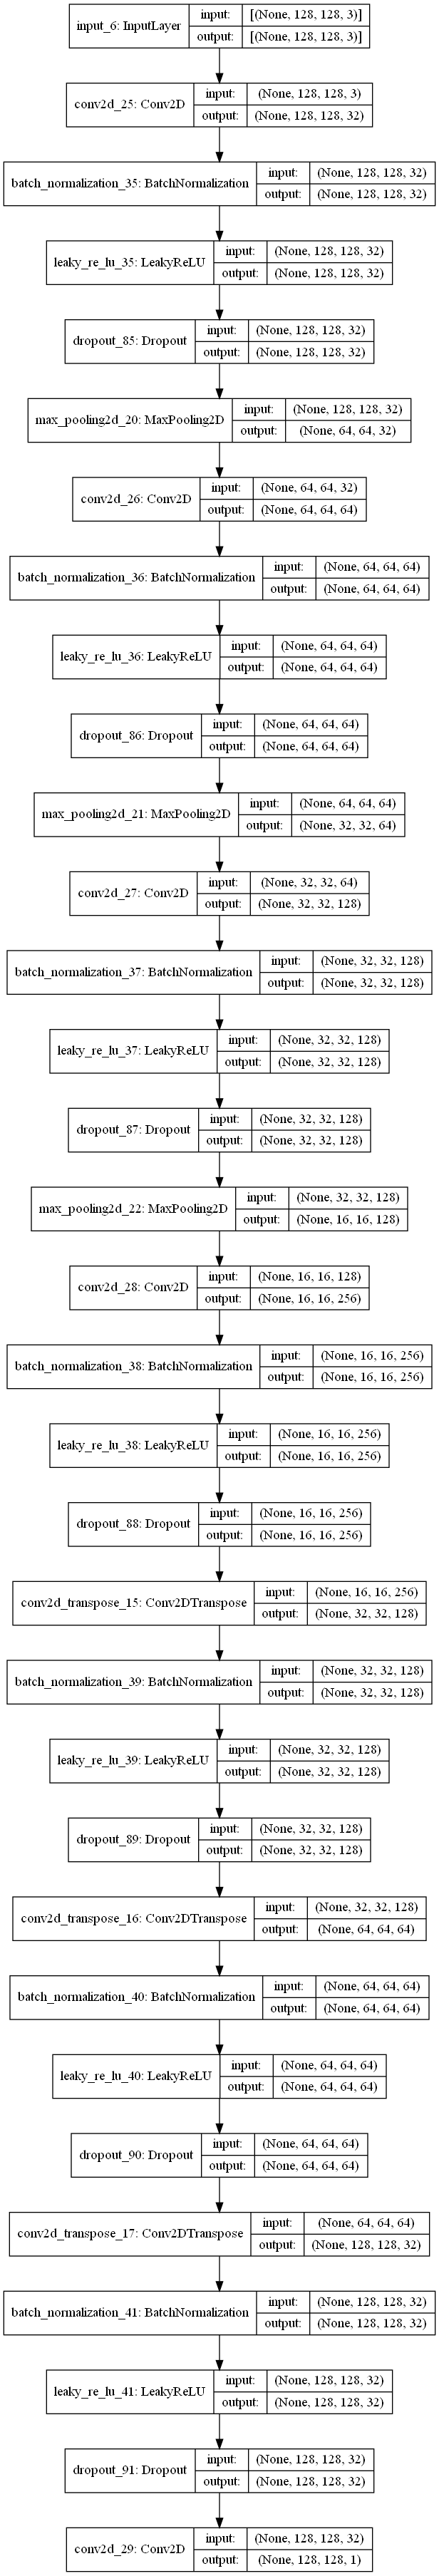

In [164]:
def build_model():
  input_image = Input(shape=(128,128,3))

  conv1=Conv2D(32,3,padding='same')(input_image)
  conv1=BatchNormalization()(conv1)
  conv1=LeakyReLU()(conv1)
  conv1=Dropout(0.25)(conv1)
  pool1=MaxPooling2D((2,2))(conv1)

  conv2=Conv2D(64,3,padding='same')(pool1)
  conv2=BatchNormalization()(conv2)
  conv2=LeakyReLU()(conv2)
  conv2=Dropout(0.25)(conv2)
  pool2=MaxPooling2D((2,2))(conv2)

  conv3=Conv2D(128,3,padding='same')(pool2)
  conv3=BatchNormalization()(conv3)
  conv3=LeakyReLU()(conv3)
  conv3=Dropout(0.25)(conv3)
  pool3=MaxPooling2D((2,2))(conv3)


  #middle block
  middle_layer=Conv2D(256,(3,3),padding='same')(pool3)
  middle_layer=BatchNormalization()(middle_layer)
  middle_layer=LeakyReLU()(middle_layer)
  middle_layer=Dropout(0.25)(middle_layer)
  middle_pool=MaxPooling2D((2,2))(middle_layer)


  deconv3=tf.keras.layers.Conv2DTranspose(128,(3,3),2,padding='same')(middle_layer)
  deconv3=BatchNormalization()(deconv3)
  deconv3=LeakyReLU()(deconv3)
  deconv3=Dropout(0.25)(deconv3)


  deconv2=tf.keras.layers.Conv2DTranspose(64,(3,3),2,padding='same')(deconv3)
  deconv2=BatchNormalization()(deconv2)
  deconv2=LeakyReLU()(deconv2)
  deconv2=Dropout(0.25)(deconv2)



  deconv1=tf.keras.layers.Conv2DTranspose(32,(3,3),2,padding='same')(deconv2)
  deconv1=BatchNormalization()(deconv1)
  deconv1=LeakyReLU()(deconv1)
  deconv1=Dropout(0.25)(deconv1)

  output = Conv2D(1,(3,3),padding='same',activation='sigmoid')(deconv1)

  model = Model(inputs=[input_image],outputs=[output])
  return model

segmentation_model=build_model()
segmentation_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=BinaryCrossentropy(), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
segmentation_model.summary()
tf.keras.utils.plot_model(segmentation_model,show_shapes=True)


In [165]:
callbacks=[tf.keras.callbacks.ModelCheckpoint("best_model_noskip.h5",save_best_only=True,monitor='val_mean_io_u_5', mode='max')]

In [166]:
segmentation_model1_history=segmentation_model.fit(Xtrain,ytrain,epochs=25,callbacks=callbacks,batch_size=32,validation_data=(Xval,yval))

Epoch 1/25
138/138 [==============================] - 120s 835ms/step - loss: 0.5876 - mean_io_u_5: 0.2992 - val_loss: 1.1319 - val_mean_io_u_5: 0.2991
Epoch 2/25
138/138 [==============================] - 140s 1s/step - loss: 0.4396 - mean_io_u_5: 0.2992 - val_loss: 0.5094 - val_mean_io_u_5: 0.2991
Epoch 3/25
138/138 [==============================] - 137s 995ms/step - loss: 0.4060 - mean_io_u_5: 0.2992 - val_loss: 1.3833 - val_mean_io_u_5: 0.2991
Epoch 4/25
138/138 [==============================] - 123s 893ms/step - loss: 0.3829 - mean_io_u_5: 0.2992 - val_loss: 0.8321 - val_mean_io_u_5: 0.2991
Epoch 5/25
138/138 [==============================] - 120s 868ms/step - loss: 0.3586 - mean_io_u_5: 0.2992 - val_loss: 0.5603 - val_mean_io_u_5: 0.2991
Epoch 6/25
138/138 [==============================] - 124s 900ms/step - loss: 0.3453 - mean_io_u_5: 0.2992 - val_loss: 0.4008 - val_mean_io_u_5: 0.2991
Epoch 7/25
138/138 [==============================] - 121s 878ms/step - loss: 0.3336 - mean

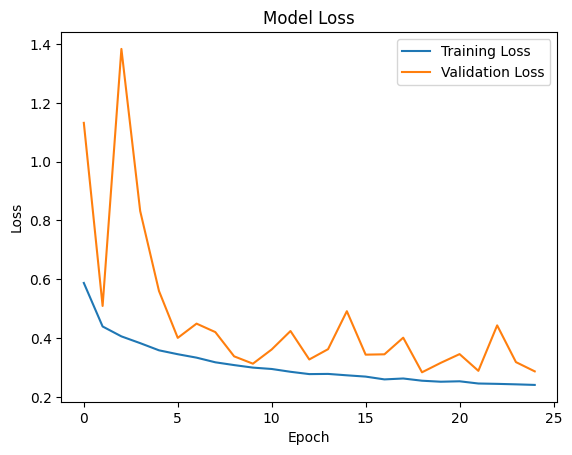

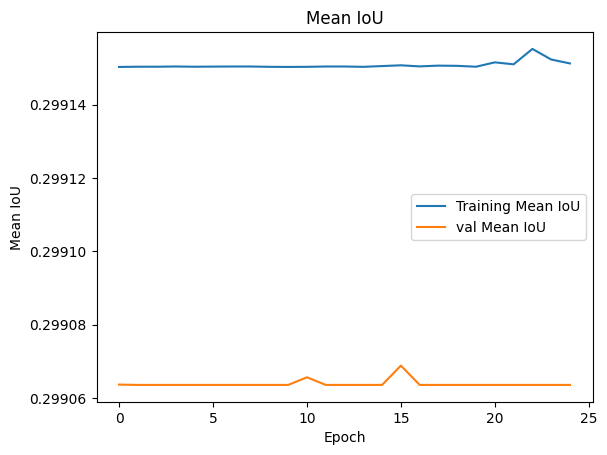

In [167]:
import matplotlib.pyplot as plt

plt.plot(segmentation_model1_history.history['loss'])
plt.plot(segmentation_model1_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


plt.plot(segmentation_model1_history.history['mean_io_u_5'])
plt.plot(segmentation_model1_history.history['val_mean_io_u_5'])
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend(['Training Mean IoU', 'val Mean IoU'])
plt.show()


# 1.F

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, 128, 128, 32) 896         input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 128, 128, 32) 128         conv2d_80[0][0]                  
__________________________________________________________________________________________________
dropout_162 (Dropout)           (None, 128, 128, 32) 0           batch_normalization_112[0][0]    
___________________________________________________________________________________________

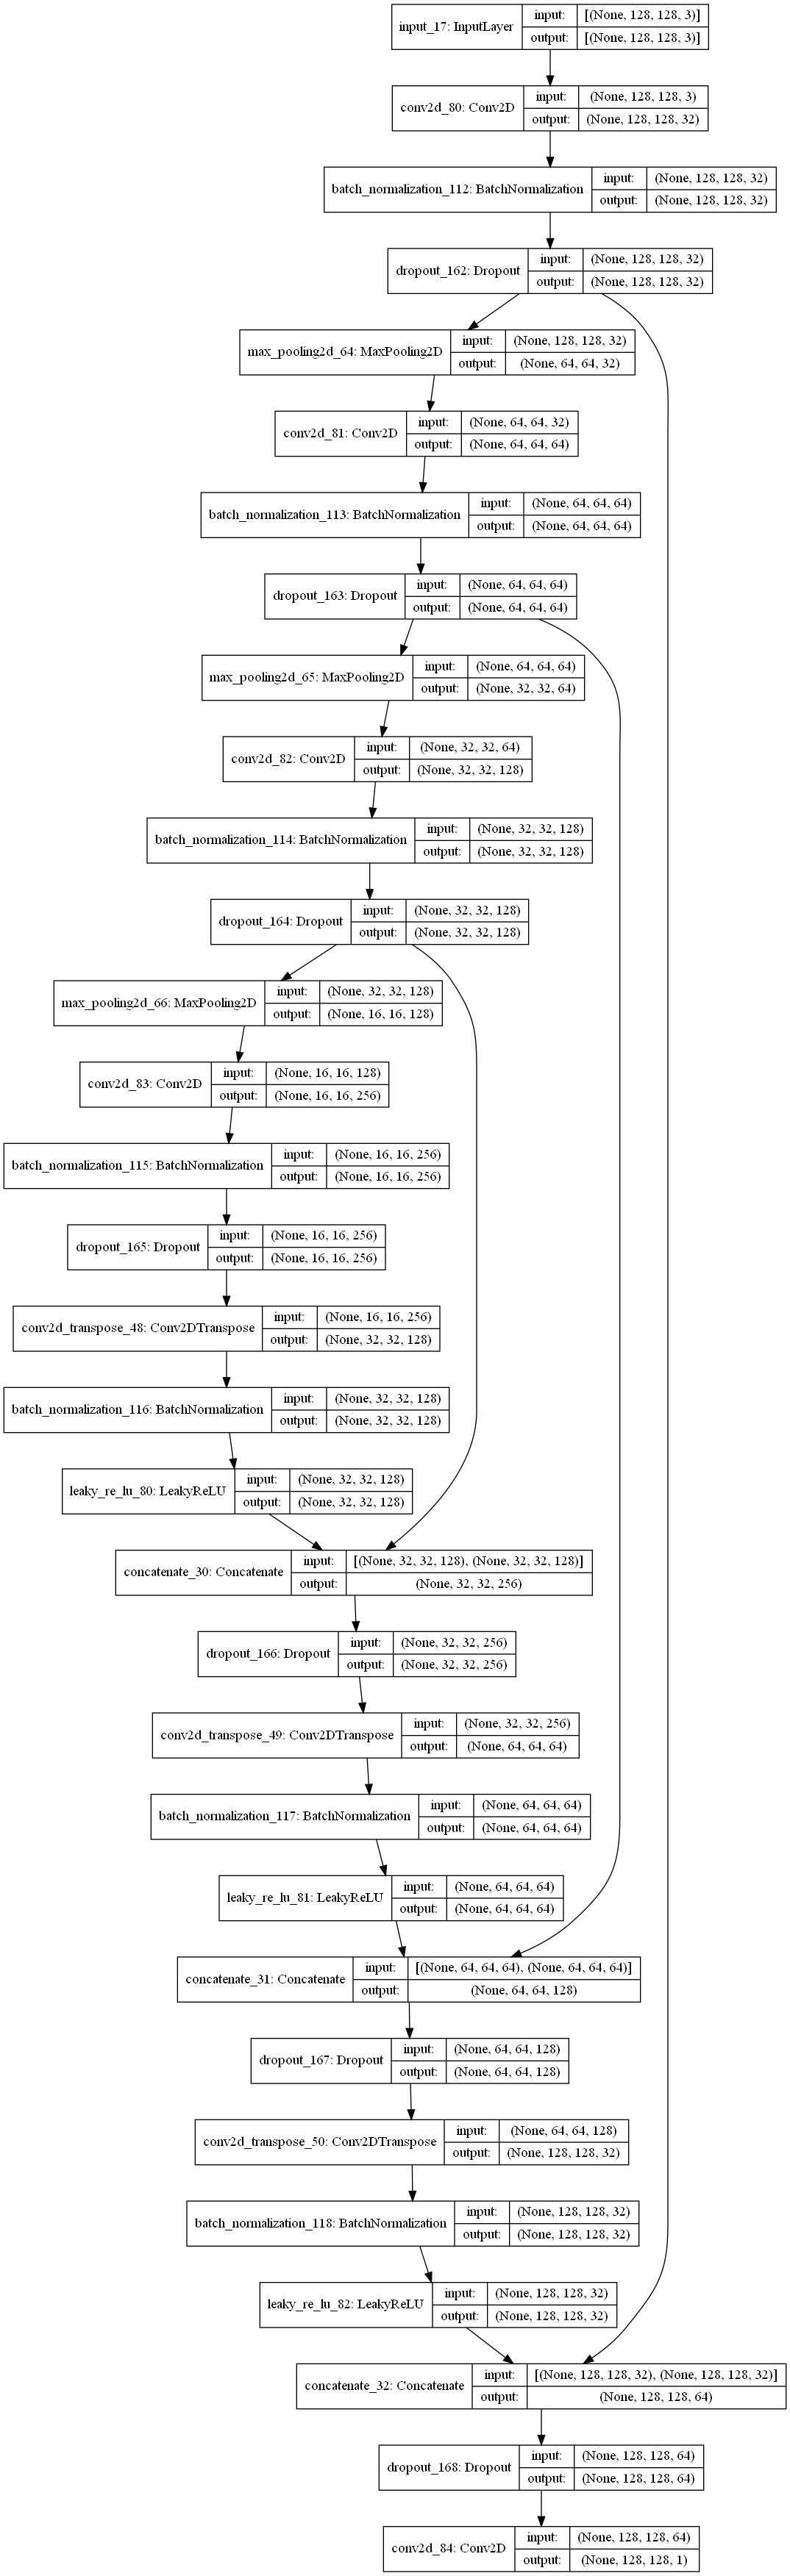

In [206]:
def build_model():
  input_image = Input(shape=(128,128,3))

  conv1=Conv2D(32,3,padding='same',activation='relu')(input_image)
  conv1=BatchNormalization()(conv1)
#   conv1=LeakyReLU()(conv1)
  conv1=Dropout(0.25)(conv1)
  pool1=MaxPooling2D((2,2))(conv1)

  conv2=Conv2D(64,3,padding='same',activation='relu')(pool1)
  conv2=BatchNormalization()(conv2)
#   conv2=LeakyReLU()(conv2)
  conv2=Dropout(0.25)(conv2)
  pool2=MaxPooling2D((2,2))(conv2)

  conv3=Conv2D(128,3,padding='same',activation='relu')(pool2)
  conv3=BatchNormalization()(conv3)
#   conv3=LeakyReLU()(conv3)
  conv3=Dropout(0.25)(conv3)
  pool3=MaxPooling2D((2,2))(conv3)




  #middle block
  middle_layer=Conv2D(256,(3,3),padding='same',activation='relu')(pool3)
  middle_layer=BatchNormalization()(middle_layer)
#   middle_layer=LeakyReLU()(middle_layer)
  middle_layer=Dropout(0.25)(middle_layer)





  deconv3=tf.keras.layers.Conv2DTranspose(128,(3,3),2,padding='same')(middle_layer)
  deconv3=BatchNormalization()(deconv3)
  deconv3=LeakyReLU()(deconv3)
  deconv3=concatenate([deconv3,conv3])
  deconv3=Dropout(0.25)(deconv3)

  deconv2=tf.keras.layers.Conv2DTranspose(64,(3,3),2,padding='same')(deconv3)
  deconv2=BatchNormalization()(deconv2)
  deconv2=LeakyReLU()(deconv2)
  deconv2=concatenate([deconv2,conv2])
  deconv2=Dropout(0.25)(deconv2)


  deconv1=tf.keras.layers.Conv2DTranspose(32,(3,3),2,padding='same')(deconv2)
  deconv1=BatchNormalization()(deconv1)
  deconv1=LeakyReLU()(deconv1)
  deconv1=concatenate([deconv1,conv1])
  deconv1=Dropout(0.25)(deconv1)

  output = Conv2D(1,(3,3),padding='same',activation='sigmoid')(deconv1)

  model = Model(inputs=[input_image],outputs=[output])
  return model

segmentation_model2=build_model()
segmentation_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss=BinaryCrossentropy(), metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
segmentation_model2.summary()
tf.keras.utils.plot_model(segmentation_model2,show_shapes=True)


In [207]:
callbacks=[tf.keras.callbacks.ModelCheckpoint("best_model_skip.h5",save_best_only=True,monitor='val_mean_io_u_16', mode='max')]

In [208]:
segmentation_model2_history=segmentation_model2.fit(Xtrain,ytrain,epochs=25,callbacks=callbacks,batch_size=16,validation_data=(Xval,yval))

Epoch 1/25
276/276 [==============================] - 134s 472ms/step - loss: 0.4637 - mean_io_u_16: 0.2992 - val_loss: 0.9122 - val_mean_io_u_16: 0.2991
Epoch 2/25
276/276 [==============================] - 134s 487ms/step - loss: 0.3771 - mean_io_u_16: 0.2992 - val_loss: 0.5352 - val_mean_io_u_16: 0.2991
Epoch 3/25
276/276 [==============================] - 155s 562ms/step - loss: 0.3476 - mean_io_u_16: 0.2992 - val_loss: 0.4217 - val_mean_io_u_16: 0.2991
Epoch 4/25
276/276 [==============================] - 145s 525ms/step - loss: 0.3218 - mean_io_u_16: 0.2992 - val_loss: 0.4319 - val_mean_io_u_16: 0.2991
Epoch 5/25
276/276 [==============================] - 145s 527ms/step - loss: 0.3101 - mean_io_u_16: 0.2992 - val_loss: 0.4956 - val_mean_io_u_16: 0.2991
Epoch 6/25
276/276 [==============================] - 149s 538ms/step - loss: 0.2961 - mean_io_u_16: 0.2992 - val_loss: 0.3811 - val_mean_io_u_16: 0.2991
Epoch 7/25
276/276 [==============================] - 156s 566ms/step - loss

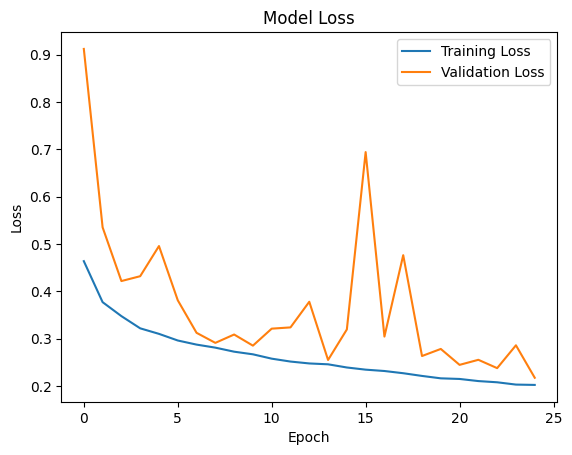

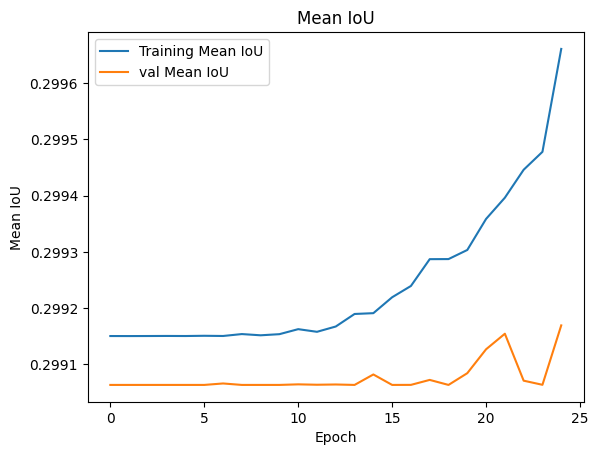

In [209]:
import matplotlib.pyplot as plt

plt.plot(segmentation_model2_history.history['loss'])
plt.plot(segmentation_model2_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()


plt.plot(segmentation_model2_history.history['mean_io_u_16'])
plt.plot(segmentation_model2_history.history['val_mean_io_u_16'])
plt.title('Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Mean IoU')
plt.legend(['Training Mean IoU', 'val Mean IoU'])
plt.show()


# 1.G

In [35]:
from matplotlib.lines import Real
BATCH_SIZE=32
def preprocess_image1(image):
    return image


def augumentation(real,fake):

  train_ds_one = (
      tf.data.Dataset.from_tensor_slices(real)
      .map(preprocess_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  )
  train_ds_two = (
      tf.data.Dataset.from_tensor_slices(fake)
      .map(preprocess_image1, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  )

  ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
  train_ds_cmu = (
    ds.shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
  )
  return train_ds_cmu

train_ds=augumentation(np.transpose(Xtrain, (0,3,1,2)),ytrain)
val_ds=augumentation(np.transpose(Xval, (0,3,1,2)),yval)

In [36]:
# pip install transformers -q


In [37]:
from transformers import TFSegformerForSemanticSegmentation


C:\Users\Manohar Vemuri\.conda\envs\main\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
model_checkpoint = "nvidia/mit-b0"
# id2label = {0: "outer", 1: "inner"}
# label2id = {label: id for id, label in id2label.items()}
transformer_model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True,
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
from IPython.display import clear_output


# def create_mask(pred_mask):
#     pred_mask = tf.math.argmax(pred_mask, axis=1)
#     pred_mask = tf.expand_dims(pred_mask, -1)
#     return pred_mask[0]


# def show_predictions(dataset=None, num=1):
#     if dataset:
#         for sample in dataset.take(num):
#             images, masks = sample["pixel_values"], sample["labels"]
#             masks = tf.expand_dims(masks, -1)
#             pred_masks = model.predict(images).logits
#             images = tf.transpose(images, (0, 2, 3, 1))
#             display([images[0], masks[0], create_mask(pred_masks)])
#     else:
#         display(
#             [
#                 sample_image,
#                 sample_mask,
#                 create_mask(model.predict(tf.expand_dims(sample_image, 0))),
#             ]
#         )

# class DisplayCallback(tf.keras.callbacks.Callback):
#     def __init__(self, dataset, **kwargs):
#         super().__init__(**kwargs)
#         self.dataset = dataset

#     def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
#         show_predictions(self.dataset)
#         print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [40]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
transformer_model.compile(optimizer=optimizer)
transformer_model.summary()

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
segformer (TFSegformerMainLa multiple                  3319392   
_________________________________________________________________
decode_head (TFSegformerDeco multiple                  395778    
Total params: 3,715,170
Trainable params: 3,714,658
Non-trainable params: 512
_________________________________________________________________


In [41]:
epochs = 15

transformer_history = transformer_model.fit(
    train_ds,
    validation_data=val_ds,verbose=1,
    epochs=epochs
)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: '<' not supported between instances of 'str' and 'Literal'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/138 [==============================] - 218s 1s/step - loss: 0.2344 - val_loss: 0.1433
Epoch 2/15
138/138 [==============================] - 168s 1s/step - loss: 0.1410 - val_loss: 0.1200
Epoch 3/15
138/138 [==============================] - 174s 1s/step - loss: 0.1204 - val_loss: 0.1104
Epoch 4/15
138/138 [==============================] - 174

In [45]:
transformer_model.save_pretrained("transformer_model.h5")

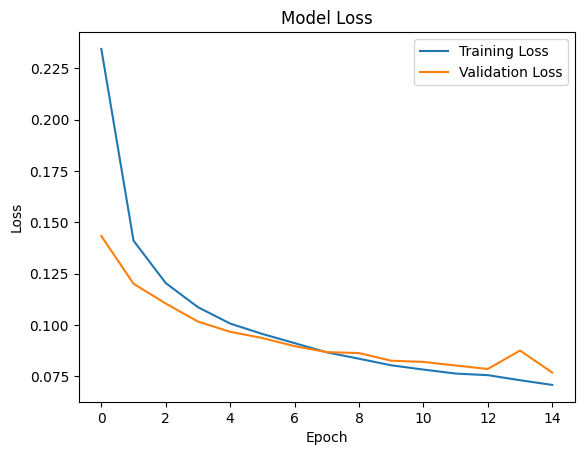

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(transformer_history.history['loss'])
plt.plot(transformer_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [84]:
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=3)
#     pred_mask = tf.expand_dims(pred_mask, -1)
    return pred_mask
pred_ds=np.transpose(Xval, (0,3,1,2))
ypred=transformer_model.predict(pred_ds)
ypred=np.array(ypred[0])
ypred=np.transpose(ypred,(0,2,3,1))
ypred=create_mask(ypred)
print(ypred.shape)

(1469, 32, 32)


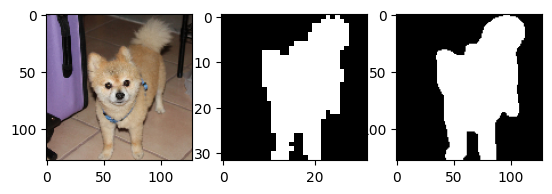

In [85]:
plt.subplot(131)
plt.imshow(Xval[0])
plt.subplot(132)
plt.imshow(ypred[0],'gray')
plt.subplot(133)
plt.imshow(yval[0],'gray')
plt.show()

# 2.A

In [391]:
def find_contours(img):
#     print(img)
#     img=preprocess_data(img)
#     print(img)
    img=(img).astype('uint8')
    img=img*255
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img=cv2.convertScaleAbs(img)
#     print(img.shape)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # take the first contour
    # cnt = contours[0]

    # compute the bounding rectangle of the contour
    x,y,w,h = cv2.boundingRect(contours[0])
#     print(x,w,y,h)
    # draw contour
    # np.zeros_like(yolo_mask)
#     m=np.zeros((128,128))
    cv2.drawContours(img,[contours[0]],-1,255,1)
#     plt.imshow(m,'gray')
#     plt.show()
    # draw the bounding rectangle
    cv2.rectangle(img,(x,y),(x+w,y+h),255,1)
    # print(img.dtype)
    # display the image with bounding rectangle drawn on it
#     plt.imshow(m,'gray')
#     plt.show()
    
    return img,x,y,w,h

In [392]:
# import required libraries
import cv2

# read the input image
# img = cv2.imread('approx.png')

# # convert the image to grayscale
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # apply thresholding on the gray image to create a binary image
# ret,thresh = cv2.threshold(gray,127,255,0)

# yolo_mask=masks*255
# _, binary_mask = cv2.threshold(yolo_mask, 0, 255, cv2.THRESH_BINARY)

# find the contours

# plt.imshow(yolo_mask)
# plt.show()





# print(yolo_mask.dtype)
# print(yolo_mask.shape)

count=0
yolo_mask=[]
bounding_box_vals=[]
images2=images
for f in range(len(final)):
#     print(os.path.join(annotations_dir,final[f][0]))
    try:
#         print(os.path.join(annotations_dir,final[f][0]))
#         mk=cv2.resize(cv2.imread(os.path.join(annotations_dir,final[f][0]),cv2.IMREAD_GRAYSCALE), (128,128))
        
        img,x,y,w,h=find_contours(masks[f])
#         plt.imshow(img,'gray')
        yolo_mask.append(img)
        if(final[f][1]=='cat'):
            c=0
        else:
            c=1
        bounding_box_vals.append([final[f][0].replace('.png','.jpg'),x,y,w,h,c])
#         print('b')
        cv2.rectangle(images2[f],(x,y),(x+w,y+h),255,1)
#         print(images2[f])
#         plt.imshow(images2[f])
    except:
        pass

In [393]:
bounding_box_vals=np.array(bounding_box_vals)

In [394]:
with open('../data/bounding_box', 'wb') as f:
    pickle.dump(bounding_box_vals, f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


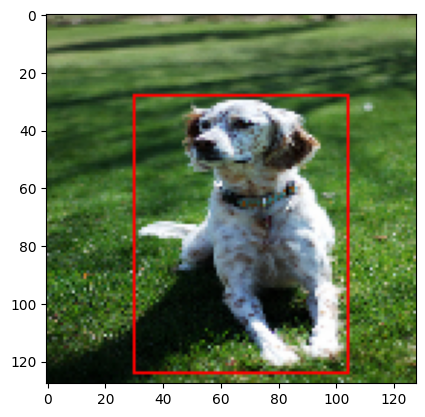

In [396]:
plt.imshow(images[0])

In [395]:
bounding_box_vals

array([['Abyssinian_1.jpg', '30', '28', '74', '96', '0'],
       ['Abyssinian_10.jpg', '29', '55', '31', '51', '0'],
       ['Abyssinian_100.jpg', '28', '25', '67', '77', '0'],
       ...,
       ['yorkshire_terrier_97.jpg', '32', '0', '84', '128', '1'],
       ['yorkshire_terrier_98.jpg', '19', '15', '101', '113', '1'],
       ['yorkshire_terrier_99.jpg', '28', '0', '82', '128', '1']],
      dtype='<U34')

In [161]:
import cv2
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import re
import os

def xml_writer2(Folder_Name,File_Name,Path_to_Folder,lst,w,h,flag):
    root=ET.Element("annotations")
    tree=ET.ElementTree(root)
    attrib={}

    #adding element to root node
    element= root.makeelement('folder',attrib)
    root.append(element)
    root[0].text=Folder_Name

    #adding element to root node
    element= root.makeelement('filename',attrib)
    root.append(element)
    root[1].text=File_Name

    #adding element to root node
    element= root.makeelement('path',attrib)
    root.append(element)
    root[2].text=Path_to_Folder

    #adding element to root node
    element= root.makeelement('source',attrib)
    root.append(element)
    ET.SubElement(root[3],'database',attrib)
    root[3][0].text='Unknown'

    # adding element to root node
    element=root.makeelement('size',attrib)
    root.append(element)

    #adding subelement to the object node
    ET.SubElement(root[4],'width',attrib)
    root[4][0].text=w
    ET.SubElement(root[4],'height',attrib)
    root[4][1].text=h
    ET.SubElement(root[4],'depth',attrib)
    root[4][2].text='1'

    #ADDING ELEMNT TO ROOT NODE
    element=root.makeelement('segmented',attrib)
    root.append(element)
    root[5].text='0'

    if (flag==1):
        i=0
#         print(lst)
    for TBD in lst:
        ##ading element to root node
        element=root.makeelement('object',attrib)
        root.append(element)
        ##adding subelement to the object node
        ET.SubElement(root[6+i],'name',attrib)
        root[6+i][0].text=TBD[0]
        ET.SubElement(root[6+i],'pose',attrib)
        root[6+i][1].text='Unspecified'
        ET.SubElement(root[6+i],'truncated',attrib)
        root[6+i][2].text='0'
        ET.SubElement(root[6+i],'difficult',attrib)
        root[6+i][3].text='0'

        ##adding subelement to the object node
        ET.SubElement(root[6+i],'bndbox',attrib)
        root[6+i][4].text=''

        ##adding subelement to the bndbox node
        ET.SubElement(root[6+i][4],'xmin',attrib)
        root[6+i][4][0].text=str(TBD[1][0])
#             print(type(root[6+i][4][0].text))
        ET.SubElement(root[6+i][4],'ymin',attrib)
        root[6+i][4][1].text=str(TBD[1][1])
        ET.SubElement(root[6+i][4],'xmax',attrib)
        root[6+i][4][2].text=str(TBD[1][2])
        ET.SubElement(root[6+i][4],'ymax',attrib)
        root[6+i][4][3].text=str(TBD[1][3])
#             print((root[6+i][4][3].text).dtype)
        i+=1
#     print(File_Name)
    File_Name=File_Name.replace(".jpg",".xml")
    name=re.sub('.png','.xml',File_Name)
#     print(File_Name)
#     print(str(name).replace(".png",".xml"))
#     print(name)
    namee = os.path.join(r'../data/xml',name)
#     print(namee)
    tree.write(namee)

col_list=["patientId","x","y","width","height","Target"]
patientId=list(df["patientId"])
x=list(df["x"])
y=list(df["y"])
width=list(df["width"])
height=list(df["height"])
Target=list(df["Target"])

overlist = []
count=0
for i in range(len(bounding_box_vals)):
#     print("i=",i)
    lst=[]
#     if(patientId[i] not in overlist):
#         overlist.append(patientId[i])
#         if(Target[i]==0):
#             flag=0
#         else:
#             flag=1
#         if (flag==1):
#             index=list(np.where(np.array(patientId)==patientId[i]))
#             for j in index:
#     #                 print(int(x[0]))
#                 xx=int(x[int(j)])
#                 yy = int(y[int(j)])
#                 ww = int(width[int(j)])
#                 hh = int(height[int(j)])
#                 xmin=xx
#                 xmax=ww
#                 ymin=yy
#                 ymax=hh
#                 lst.append([patientId[int(j)],(xmin,ymin,xmax,ymax)])
#         else:    
#             print(lst)
    

    lst=[[bounding_box_vals[i][0],[eval(i) for i in bounding_box_vals[i][1:]]]]
#     lst=bounding_box_vals[i]
#     print(lst[1])
#     print(str(lst[1][1]))1
#     print(lst)
    iname=lst[0][0]
#     print(iname)
    src="../data/images/"+iname
#         print(str(src))
    img=cv2.imread(src)
#         print(img)
#         yyy,xxx=img.shape[:2]
    yyy,xxx=(128,128)
#         print(img.shape[:2])
    widthh=str(128)
    heightt=str(128)
    Path_to_Folder=os.path.join('../data/images/'+iname)
    xml_writer2('JPEGImages',iname,Path_to_Folder,lst,str(widthh),str(heightt),1)

# 2.B

In [400]:
!curl https://pjreddie.com/media/files/yolov3.weights

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  236M    0 97996    0     0   303k      0  0:13:18 --:--:--  0:13:18  303k
  6  236M    6 14.8M    0     0  11.5M      0  0:00:20  0:00:01  0:00:19 11.5M
  9  236M    9 23.1M    0     0   9.9M      0  0:00:23  0:00:02  0:00:21  9.9M
 14  236M   14 34.3M    0     0  10.4M      0  0:00:22  0:00:03  0:00:19 10.4M
 18  236M   18 44.7M    0     0  10.4M      0  0:00:22  0:00:04  0:00:18 10.4M
 23  236M   23 54.7M    0     0  10.3M      0  0:00:22  0:00:05  0:00:17 10.9M
 27  236M   27 64.3M    0     0  10.2M      0  0:00:23  0:00:06  0:00:17  9.8M
 31  236M   31 73.7M    0     0  10.1M      0  0:00:23  0:00:07  0:00:16 10.1M
 33  236M   33 80.3M    0     0  9759k      0  0:00:24  0:00:08  0:00:16 9170k
 35  236M   35 83.9M    0     0  9248k      0  0:00

<�*ª»:8¼:#»E�°¼f+¬¼Ø*r¼ï9¼Í¥Þ»æ-<¼99»V2‘»ùû»2ç8»R`"»i]¸¼ÇþR;üŠ¼§y�º|›„<P¢<„ð¢;·(�»Ø•�<|ƒÝ;U/î;‘§¼Î(;ò±ü¹fIÞºhíc»£·»¬ù>¼—è¼pD
¼Ï“¼aØ ¼è…<Ê7å»Ñ"*;E˜%»nñb¼ž›¼ñÌŒ¼Ó¼¼nðõ¼”¼ð¶<P<íDä»MN» ïm:ÒŠÁºFëŸ<ü>R»Â
u<uÖº<¥fI<²v�;r‚¼w©<D²2=D!�=çJ‚= ˜Á<7Ø1=Õ3>=Ñ“¼å{—¼º¦»úw»¿ù:Žq	<f
P<„Bäº$Z;Î�<ŽÆ…¼ZïS:Èá?<Ö“Æ»…@Â;¤÷º·Áð;3š¡»K|ç»¬2S<„\\»º³d¼
[Î»[\¹¼,[“¼bŽ„¼µ5½ÿ ½Æ"!¼‹ì/¼ <€
|<Ä0d¹JÙ¼_'<À1‚¼)»¤&8¼YØÀ»q#¼mJ¼�³;ø\;~ƒNºzrýºtF²<hË�ºyï;¦Î<4°ç<€Cì<Ü¼Ü˜„¼
[;‚ÑÝ»h±“¼¦…+¼’»‘¼g�;Ã¼Ã¼Ä”s¼%Ö» o’¼H¶W»Èdç¼Bµ¼ŸºvðB;Æ€ö;¾;|7|<îžz»Äœ�<†<xíˆº.îu·ÂA¼ô y¼?ƒÌ<Ë·<.ðV<mžŸ<}ˆ*=Š?¿<„½À¼ŽOÝ¼ôÌ¢¼Ì´×<”ÇP=T4Þ<Ü†Ø<- ?=L8=Ìb=¶%?<M�=(y™<ôÐÄ<
Ð\=}ëI»=m¼6u<[m'¼=4	¼Oà¼A#…¼XýA¼2™-¼éïX¼îø€»jGÁ»H]Â¼£l½œIú¼íÆ¼)¬¢¼ÿDƒ¼óÇ¼ù¨–¼”ß£º„³
¼vìn<Ô§Üºnç»Ó²=g=Ž‹<-=T=Òße<ûÀÇ»¯Ö9<rÀ»ÓËE¼�q�¼l&¼ï‘]:þÈ»0Ë;|‘›<Àn’»Û`¼Êì>=«Ëã;Œü:~þ¬<boM<"r%;¾Í¼…Ç\¼”–Þ¼C6<À½W<îw<ò®<!ê>ºx¡<7ý�¼Ç¥K¼ÊŸ‹»å‹¼äÎ‘»‚8ž;a;¨[<
Õ<	Næ¼Jëv¼)ó«»nC§;\›ûº½àŸ¼w†	»T¯;I Ž<ð¤»1ä¼TÿÍ¼X�¢<òÔ;
%<BãJ¼²Ê�¼ƒ¼evD

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



=Á«Ï<@z�½�o†<ÚJ;,:)=×¥T<%•O=NCÈ½r½ŠŠ=™™¼þ"0;ŒˆY=xXV<gó‚½ Þ•½Î‡L<Þ€½ S»…&<Ž¬=4âÝ¼D9½½ná™<¡@»D§=æ´õ=2?½L¯ê<–,¯¼˜Û¼¥5~<HJ!¼ñ¸¼´lÝ;(€	:Áè™¼ Õf½àû¼X
Ì<*ˆ½ „‹<U’1¼ÿ�<ºbu¼.Ë�¼,*õ¼<^�<IQ=„ah=g�e½‚€=ü—°¹c'»<
Œ|<üø‚=š6B=ˆÁ»Õ®\½ˆ×d;ô¢¼MQ˜<;¹¦»`È$=<½´¼;³©=àæŽ<ø®½`
#½ì­¼nfë=½…‘=³sª<|Ã½²ü;X&=T½ìP<Ëîºöž¼•¼S¼œOŒ¼´/µ¼¹W¼¾kÓ<‘3ž½¸# ¼²±½ª7Š9	Ñ<ôÒ½\å¶;t¯¼�§½�+6=*ö]½v«ú<z&À¼ÒðO=OÂw¼ˆÜ½f}y»�h½Ï›=½<ã<<në»ú}¼²Ž€<lY~=�#‚½@… ¼ðDÛ<ä¿Ø¼Ím ½ŠÂéºl«›=`›³=¢Ð‰½}þ»rh3;IÄ;¨˜Ì< mì¼Ëàç¼ò�<jw½5F½ûZÿºÃ6=ýu�¼¾*Ì<ˆÞƒ=² ¼\§Y½>µG=%z³¼aô<çT“=°µ<®.	¼ìÊ^½k8<¢cK=nË¼Äc«=�“‚½¶¯½w…5=ª2½ëe…½ìÏà¼’|p»Jšb½N1<9\½�ø�½­¤”¼T(m=sLÕ¼"Î¼~úD½“aP¼-d<kùD=NHN=@¨ã<)e= Ð<†ð'=}�<#ñ“=ôP½¤¢R½Éú»W`½äKL¼N« = T™¼ºM
;C”.½M±<xÝ¼Ø±T=”ˆ•¼ôD•<ÊI=ô+Ìº&??½4#<2¼¼BýT=b®j=UÜ=¬›ƒ< ¯Ø<] #¼lí„;ù l=¾<t=È=8@v;L®¼–=<!�=°kÄ<kH=RJ¤=‹¦$»"Lî;à¸@:�b�½‚ƒ½%˜=ë‹=@¡Ž¼äŠÇ<½Äí¼}ð<Æ^º¼ç¹í;6™N½��Ò¼B¸€½þG•½Õ—¼îH¢<:ƒ=&?‡=Ô¼ý4=zk�¼)2<€{´¼ûNi<$ü3<÷Cä<Ì`Ì¼\2‹<£‘ÿ<q=.½ëQ‹¼œ¶½¿(=Þ¾’< 	õ<4�=€‰ƒ¼§†”<œæŽ

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 2.C

In [889]:
import sys
sys.path.append(r'keras-yolo3')
# from yolo3_one_file_to_detect_them_all import make_yolov3_model,WeightReader,decode_netout,correct_yolo_boxes,do_nms,draw_boxes,preprocess_input
from yolo3_one_file_to_detect_them_all import *

In [890]:
weight_path=input('please enter the weights path:')
model = make_yolov3_model()
weight_reader = WeightReader(weight_path)
weight_reader.load_weights(model)
# Model.load_weights(filepath, skip_mismatch=False, by_name=False, options=None)
model.save('yolo_model.h5')


loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

# 2.D

In [891]:
yolo_model=load_model('yolo_model.h5')
yolo_model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_12[0][0]                   
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
______________________________________________________________________________________

In [654]:
net_h,net_w=416,416
boxes = []
anchors = [[116,90,  156,198,  373,326],  [30,61, 62,45,  59,119], [10,13,  16,30,  33,23]]
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", \
              "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", \
              "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", \
              "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", \
              "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard", \
              "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana", \
              "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", \
              "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse", \
              "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", \
              "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
obj_thresh, nms_thresh = 0.75, 0.45

In [881]:
image_path=input('enter image directory')

enter image directorykeras-yolo3/cat.jpg


In [882]:
# image_path=r'keras-yolo3/cat.jpg'
image=cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image=np.array(image)
image=image.astype('float64')
image_h, image_w, _ = image.shape
new_image=preprocess_input(image,net_h,net_w)


In [883]:
ypred=yolo_model.predict(new_image)
for i in range(len(ypred)):
        # decode the output of the network
        boxes += decode_netout(ypred[i][0], anchors[i], obj_thresh, nms_thresh, net_h, net_w)

In [884]:
correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w)

In [885]:
do_nms(boxes, nms_thresh)

In [886]:
draw_boxes(image, boxes, labels, obj_thresh)

array([[[30., 38., 27.],
        [30., 38., 27.],
        [30., 38., 27.],
        ...,
        [43., 51., 38.],
        [41., 49., 36.],
        [40., 48., 35.]],

       [[29., 37., 26.],
        [29., 37., 26.],
        [30., 38., 27.],
        ...,
        [43., 51., 38.],
        [42., 50., 37.],
        [40., 48., 35.]],

       [[29., 37., 26.],
        [29., 37., 26.],
        [29., 37., 26.],
        ...,
        [44., 52., 39.],
        [43., 51., 38.],
        [41., 49., 36.]],

       ...,

       [[12., 19., 11.],
        [11., 18., 10.],
        [11., 18., 10.],
        ...,
        [15., 23., 12.],
        [15., 23., 12.],
        [15., 23., 12.]],

       [[12., 19., 11.],
        [11., 18., 10.],
        [11., 18., 10.],
        ...,
        [15., 23., 12.],
        [15., 23., 12.],
        [15., 23., 12.]],

       [[12., 19., 11.],
        [11., 18., 10.],
        [10., 17.,  9.],
        ...,
        [15., 23., 12.],
        [15., 23., 12.],
        [15., 23., 12.]]

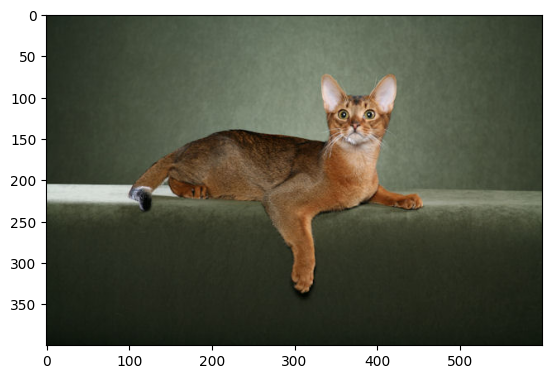

In [887]:
plt.imshow((image).astype('uint8'))

In [888]:
cv2.imwrite(image_path[:-4] + '_detected' + image_path[-4:], (image).astype('uint8'))

True

# 2.E

In [686]:
import json
from voc import parse_voc_annotation
with open('keras-yolo3/config.json') as config_buffer:    
        config = json.loads(config_buffer.read())

    ###############################
    #   Create the validation generator
    ###############################  
valid_ints, labels = parse_voc_annotation(
    config['valid']['valid_annot_folder'], 
    config['valid']['valid_image_folder'], 
    config['valid']['cache_name'],
    config['model']['labels']
)

In [687]:
labels = labels.keys() if len(config['model']['labels']) == 0 else config['model']['labels']
labels = sorted(labels)

valid_generator = BatchGenerator(
    instances           = valid_ints, 
    anchors             = config['model']['anchors'],   
    labels              = labels,        
    downsample          = 32, # ratio between network input's size and network output's size, 32 for YOLOv3
    max_box_per_image   = 0,
    batch_size          = config['train']['batch_size'],
    min_net_size        = config['model']['min_input_size'],
    max_net_size        = config['model']['max_input_size'],   
    shuffle             = True, 
    jitter              = 0.0, 
    norm                = normalize
)

In [698]:
# infer_model = load_model(config['train']['saved_weights_name'])

    # compute mAP for all the classes
average_precisions = evaluate(yolo_model, valid_generator)

# print the score
for label, average_precision in average_precisions.items():
    print(labels[label] + ': {:.4f}'.format(average_precision))
print('mAP: {:.4f}'.format(sum(average_precisions.values()) / len(average_precisions)))

cat: 0.0000
dog: 0.0000
mAP: 0.0000


In [851]:
def bb_intersection_over_union(boxA, boxB):
    xA = max(int(boxA[0]), int(boxB[0]))
    yA = max(int(boxA[1]), int(boxB[1]))
    xB = min(int(boxA[2]), int(boxB[2]))
    yB = min(int(boxA[3]), int(boxB[3]))
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (int(boxA[2]) - int(boxA[0]) + 1) * (int(boxA[3]) - int(boxA[1]) + 1)
    boxBArea = (int(boxB[2]) - int(boxB[0]) + 1) * (int(boxB[3]) - int(boxB[1]) + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

In [737]:
import pandas as pd
pred = pd.read_csv('pred_label.txt', skiprows=6, delimiter=",", names=["image_name", "y", "w","h","species","score"])
pred[['image_name', 'x']] = pred['image_name'].str.split(' ', n=1, expand=True)
new_order = ['image_name', 'x', 'y', 'w', 'h', "species",'score']
pred = pred.reindex(columns=new_order)

In [764]:
import pandas as pd
gt = pd.read_csv('gt_label.txt', skiprows=6, delimiter=",", names=["image_name", "y", "w","h","species"])
gt[['image_name', 'x']] = gt['image_name'].str.split(' ', n=1, expand=True)
new_order = ['image_name', 'x', 'y', 'w', 'h', 'species']
gt = gt.reindex(columns=new_order)

In [845]:
ground_truth_bb=gt.iloc[:,1:5]
ground_truth_label=gt.iloc[:,5]
pred_bb=pred.iloc[:,1:5]
pred_label=pred.iloc[:,5]
confidence_scores=gt.iloc[:,5]
confidence_scores=np.array(confidence_scores)

In [811]:
for i in ran
iou=bb_intersection_over_union(np.array(pred_bb.head(1))[0],np.array(ground_truth_bb.head(1))[0])
print(iou)

0.23329824192020213


In [869]:
ground_truth_bb.shape

(3656, 4)

In [870]:
pred_bb.shape

(3478, 4)

In [ ]:
gt_path=input()
pred_path=input()

In [893]:
# gt_path=('gt_label.txt')
# pred_path=('pred_label.txt')
gt=[]
with open(gt_path, 'r') as f:
    for line in f:
        gt.append(line)
pd=[]
with open(pred_path, 'r') as f:
    for line in f:
        pd.append(line)
gt1=[]
for i in gt:
    f=i.split(' ')
    gt1.append([f])
pd1=[]
for i in pd:
    f=i.split(' ')
    pd1.append([f])
iou=[]
for i in range(0,len(pd1)):
    for j in range(0,len(gt1)):
        if(pd1[i][0][0]==gt1[j][0][0]):
            k=j
            mm=pd1[i][0][0]
            ggt=gt1[j][0][1]
            ppt=pd1[i][0][1]
            ggt=ggt.split(',')
            ggt=ggt[0:4]
            ppt=ppt.split(',')
            ppt=ppt[0:4]
            inc=(int(ggt[2])-int(ppt[0]))*(int(ggt[3])-int(ppt[1]))
            inc=abs(inc)
            ggta=(int(ggt[2])-int(ggt[0]))*(int(ggt[1])-int(ggt[3]))
            ggta=abs(ggta)
            ppta=(int(ppt[2])-int(ppt[0]))*(int(ppt[1])-int(ppt[3]))
            ppta=abs(ppta)
            iou1=inc/(ppta+ggta-inc)
            iou.append([pd1[i][0][0],iou1])

In [894]:
ccc=[]
iou2=[]
for i in range(len(iou)):
    if(iou[i][1]<=1 and iou[i][1]>0):
        ccc.append(iou[i][1])
        iou2.append([iou[i][0],iou[i][1]])

In [897]:
def mapap(ccc,v):
    g=0
    sum1=0
    for i in range(0,len(ccc)):
        if(ccc[i]<=v):
            g=g+1
            sum1=sum1+ccc[i]
    return sum1/g
print('mAP 0.25',mapap(ccc,0.25))
print('mAP 0.5',mapap(ccc,0.5))
print('mAP 0.75',mapap(ccc,0.75))
print('mAP 0.95',mapap(ccc,0.95))

mAP 0.25 0.10510885236791656
mAP 0.5 0.2934204082733345
mAP 0.75 0.5353968669221011
mAP 0.95 0.846715722252858


In [900]:
# pip freeze > requirements.txt